In [ ]:
#Importing libraries
import numpy as np
from numpy import pi,sin, cos

import math
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
get_ipython().run_line_magic('matplotlib', 'qt')

In [3]:
#Defining the values
#trajectory plan
clr_height = 4 #cm, Clearance height
L_span = 8 #cm, length of trajectory plan Stance plan from rest point
v_d = 0.7 #m/s

T_st = 2*L_span/(100*v_d) #stance phase period
T_sw = 0.15 #swing phase period
T_stride = T_st +T_sw

precision = 0.01
legNum = 1

S_st_i = 5 #stance phase
S_sw_i = 5 #Swing phase

phase= np.array([0.5,0.5,0.5,0.5])
loopstart = 0
loopEnd = 0
looptime = 0

#control points
ds = [0,0.5,0,0.5]

#empty variables
t1 = 0
t2 = 0
t3 = 0
t4 = 0

t_elapsed_ref = 0.2 #varies from 0 to 0.33
t_i = np.array([[t1, t2, t3, t4]])

#Defining empty variables to store x, y, z co-ordinates
x = 0
y = 0
z = 0

bodyHeight = 18 #cm
delta = -0.85

#Bernstein control points
bezierControlPoints = np.array([[-L_span,0.0-bodyHeight],
                                [-L_span*1.4,0.0-bodyHeight],
                                [-L_span*1.5,clr_height*0.9-bodyHeight],
                                [-L_span*1.5,clr_height*0.9-bodyHeight],
                                [-L_span*1.5,clr_height*0.9-bodyHeight],
                                [0.0,clr_height*0.9-bodyHeight],
                                [0.0,clr_height*0.9-bodyHeight],
                                [0.0,clr_height*1.157-bodyHeight],
                                [L_span*1.5,clr_height*1.157-bodyHeight],
                                [L_span*1.5,clr_height*1.157-bodyHeight],
                                [L_span*1.4,0.0-bodyHeight],
                                [L_span,0.0-bodyHeight]])


#femur
femur= 12 #cm

#tibia
tibia = 11.5 #cm

#hip
hip = 0

#define all empty arrays to store angel,x and z values for each leg.
angels = []
alpha_list = []
beta_list = []
gamma_list = []
alpha_list2 = []
beta_list2 = []
gamma_list2 = []
alpha_list3 = []
beta_list3 = []
gamma_list3 = []
alpha_list4 = []
beta_list4 = []
gamma_list4 = []

x_list1 = []
z_list1 = []
x_list2 = []
z_list2 = []
x_list3 = []
z_list3 = []
x_list4 = []
z_list4 = []
#Defining the Functions
def nCr(n, r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def bernstein(S, N, K, v):
    return nCr(N, K)*(1-S)**(N-K)*S**K*v

#Inverse Kinamatics
def legIK(x, y, z):
    R = math.sqrt(x**2+y**2+z**2) #def alpha
    R1 = math.sqrt(z**2+y**2)
    R2 = math.sqrt(R**2+hip**2)
    
    theta1 = math.atan2(-z, y)
    theta2 = math.acos(hip/R1)
    
    alpha = (theta2-theta1)*180/math.pi
    phi1 = math.asin(x/R2) #def beta
    
    temp1 = (femur**2+R2**2-tibia**2)/(2*femur*R2)
    
    if temp1>1:
        temp1 = 1
    elif temp1<-1:
        temp1=-1
        
    phi2 = math.acos(temp1)
    beta = (phi1-phi2)*180/math.pi
    
    temp2 = (femur**2+tibia**2-R2**2)/(2*femur*tibia) #def gamma
    
    if temp2>1:
        temp2 = 1
        
    elif temp2<-1:
        temp2=-1
        
    psi = math.acos(temp2)
    gamma= (math.pi-psi)*180/math.pi
    
    return np.array([alpha, beta, gamma])

In [4]:
t = 0.0 #clock started
t_TD_ref = t #initialized from touchdown
start = time.perf_counter()
legNum = 1
loopend = 0
loopstart = 0

for i in range(0,1):
    S_st_i=0
    S_sw_i=0
    TD=False
    
    while(not TD):
        loopStart=time.perf_counter()
        t_elapse_ref = t - t_TD_ref
        TD=False
        
        if t_elapse_ref >= T_stride:
            t_elapse_ref = 0
            TD = True
            
        if TD:
            t_TD_ref = t
            
        t_i = t_elapse_ref - T_stride * np.array(ds)
        
        for legTime in t_i:
            if legTime < -T_sw:
                legTime += T_stride
                
            if legTime>0 and legTime<T_st:
                x=0
                y=0
                z=0
                S_st_i = legTime/T_st
                phase[legNum-1]=S_st_i
                x=L_span*(1-2*S_st_i)+0
                z=delta*(math.cos(math.pi*x/(2*L_span))+0 )- bodyHeight
                
                angles=legIK(x, y, z)
                
            if legTime>= -T_sw and legTime<=0:
                x=0
                y=0
                z=0
                S_sw_i = (legTime+T_sw)/T_sw
                phase[legNum-1]=S_sw_i
                
                for index in range(0,12):
                    x+=bernstein(S_sw_i, 11, index, bezierControlPoints[index][0])
                    z+=bernstein(S_sw_i, 11, index, bezierControlPoints[index][1])
                
                angles=legIK(x, y, z)
                
            elif legTime>= T_st and legTime<=T_stride:
                x=0
                y=0
                z=0
                S_sw_i = (legTime-T_st)/T_sw
                phase[legNum-1]=S_sw_i
                
                for index in range(0,12):
                    x+=bernstein(S_sw_i, 11, index, bezierControlPoints[index][0])
                    z+=bernstein(S_sw_i, 11, index, bezierControlPoints[index][1])
                
                angles=legIK(x, y, z)
                
            if legNum==1:
                val0=angles[0]*math.pi/180
                val1=angles[1]*math.pi/180
                val2=angles[2]*math.pi/180
                alpha_list.append(val0)
                beta_list.append(val1)
                gamma_list.append(val2)
                x_list1.append(x)
                z_list1.append(z)
                
            if legNum==2:
                val0=angles[0]*math.pi/180
                val1=angles[1]*math.pi/180
                val2=angles[2]*math.pi/180
                alpha_list2.append(val0)
                beta_list2.append(val1)
                gamma_list2.append(val2)
                x_list2.append(x)
                z_list2.append(z)
                
            if legNum==3:
                val0=angles[0]*math.pi/180
                val1=angles[1]*math.pi/180
                val2=angles[2]*math.pi/180
                alpha_list3.append(val0)
                beta_list3.append(val1)
                gamma_list3.append(val2)
                x_list3.append((float(x) + 40))
                z_list3.append(z)
                
            if legNum==4:
                val0=angles[0]*math.pi/180
                val1=angles[1]*math.pi/180
                val2=angles[2]*math.pi/180
                alpha_list4.append(val0)
                beta_list4.append(val1)
                gamma_list4.append(val2)
                x_list4.append((float(x)+40))
                z_list4.append(z)
                
            legNum+=1
        legNum=1
        t_elapse_ref +=precision
        t +=precision
        loopEnd=time.perf_counter()
        loopTime=loopEnd-loopStart

In [5]:
# Leg Parameters
Femur_one_leg = femur
Tibia_one_leg = tibia

# Define Empty Variables to Store x and y co-ordinate for each leg

## Leg 1
# Femur
X1 = np.zeros(len(beta_list))
Y1 = np.zeros(len(beta_list))
# Tibia
X2 = np.zeros(len(gamma_list))
Y2 = np.zeros(len(gamma_list))

## Leg 2
# Femur
X1_2 = np.zeros(len(beta_list2))
Y1_2 = np.zeros(len(beta_list2))
# Tibia
X2_2 = np.zeros(len(gamma_list2))
Y2_2 = np.zeros(len(gamma_list2))

## Leg 3
# Femur
X1_3 = np.zeros(len(beta_list3))
Y1_3 = np.zeros(len(beta_list3))
# Tibia
X2_3 = np.zeros(len(gamma_list3))
Y2_3 = np.zeros(len(gamma_list3))

## Leg 4
# Femur
X1_4 = np.zeros(len(beta_list4))
Y1_4 = np.zeros(len(beta_list4))
# Tibia
X2_4 = np.zeros(len(gamma_list4))
Y2_4 = np.zeros(len(gamma_list4))

In [6]:
## Leg 1
for index, (beta,gamma) in enumerate(zip(beta_list,gamma_list)):
  # Femur
  x1 = Femur_one_leg*cos(-beta - (pi/2))
  y1 = Femur_one_leg*sin(-beta - (pi/2))
  # Tibia
  x2 = x1+Tibia_one_leg*cos(-pi/2 - (beta+gamma))
  y2 = y1+Tibia_one_leg*sin(-pi/2 - (beta+gamma))

  # Storing position values for each beta and gamma angles
  X1[index] = x1
  Y1[index] = y1
  X2[index] = x2
  Y2[index] = y2

## Leg 2
for index2, (beta2,gamma2) in enumerate(zip(beta_list2,gamma_list2)):
  # Femur
  x1_2 = Femur_one_leg*cos(-beta2 - (pi/2))
  y1_2 = Femur_one_leg*sin(-beta2 - (pi/2))
  # Tibia
  x2_2 = x1_2+Tibia_one_leg*cos(-pi/2 - (beta2+gamma2))
  y2_2 = y1_2+Tibia_one_leg*sin(-pi/2 - (beta2+gamma2))

  # Storing position values for each beta and gamma angles
  X1_2[index2] = x1_2
  Y1_2[index2] = y1_2
  X2_2[index2] = x2_2
  Y2_2[index2] = y2_2

## Leg 3
for index3, (beta3,gamma3) in enumerate(zip(beta_list3,gamma_list3)):
  # Femur
  x1_3 = 40+ Femur_one_leg*cos(-beta3 - (pi/2))
  y1_3 = Femur_one_leg*sin(-beta3 - (pi/2))
  # Tibia
  x2_3 = x1_3+Tibia_one_leg*cos(-pi/2 - (beta3+gamma3))
  y2_3 = y1_3+Tibia_one_leg*sin(-pi/2 - (beta3+gamma3))

  # Storing position values for each beta and gamma angles
  X1_3[index3] = x1_3
  Y1_3[index3] = y1_3
  X2_3[index3] = x2_3
  Y2_3[index3] = y2_3

## Leg 4
for index4, (beta4,gamma4) in enumerate(zip(beta_list4,gamma_list4)):
  # Femur
  x1_4 = 40+Femur_one_leg*cos(-beta4 - (pi/2))
  y1_4 = Femur_one_leg*sin(-beta4 - (pi/2))
  # Tibia
  x2_4 = x1_4+Tibia_one_leg*cos(-pi/2 - (beta4+gamma4))
  y2_4 = y1_4+Tibia_one_leg*sin(-pi/2 - (beta4+gamma4))

  # Storing position values for each beta and gamma angles
  X1_4[index4] = x1_4
  Y1_4[index4] = y1_4
  X2_4[index4] = x2_4
  Y2_4[index4] = y2_4

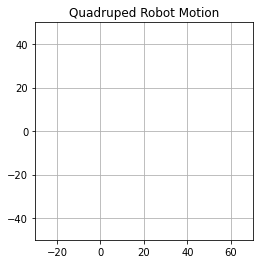

In [7]:
# Set the Parameters of the Animation
fig = plt.figure()
ax = fig.add_subplot(111, aspect = 'equal', autoscale_on = False, xlim = (-30,70), ylim = (-50, 50))
ax.grid()
ax.set_title('Quadruped Robot Motion')

# Setting Line Color For Each Line
line,  = ax.plot([],[],'o-',lw = 5, color='Brown')
line2, = ax.plot([],[],'o-',lw = 5, color='Blue')
line3, = ax.plot([],[],'o-',lw = 5, color='Brown')
line4, = ax.plot([],[],'o-',lw = 5, color='Blue')

# Initialization Function
def init():
  line.set_data([],[])
  line2.set_data([],[])
  line3.set_data([],[])
  line4.set_data([],[])

  return line,line2,line3,line4

# Animation Function
def animate(i):
  x_points = [0, X1[i], X2[i]]
  y_points = [0, Y1[i], Y2[i]]

  x2_points = [0, X1_2[i], X2_2[i]]
  y2_points = [0, Y1_2[i], Y2_2[i]]

  x3_points = [40, X1_3[i], X2_3[i]]
  y3_points = [0, Y1_3[i], Y2_3[i]]

  x4_points = [40, X1_4[i], X2_4[i]]
  y4_points = [0, Y1_4[i], Y2_4[i]]

  line.set_data(x_points, y_points)
  line2.set_data(x2_points, y2_points)
  line3.set_data(x3_points, y3_points)
  line4.set_data(x4_points, y4_points)

  return line,line2,line3,line4

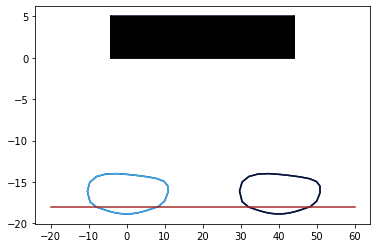

In [8]:
# Creating the Animation of the Robot
ani = animation.FuncAnimation(fig, animate, init_func= init, frames= len(X1), interval = 100, blit = True, repeat = True)

# Plotting the Reference Circle for the Robot Legs to Follow
plt.plot(X2,Y2, '#05143b')
plt.plot(X2_2,Y2_2, '#37acf0')
plt.plot(X2_3,Y2_3, '#05143b')
plt.plot(X2_4,Y2_4, '#05143b')

# PLotting the Legs 
# Ground Plot
plt.plot([-20,60],[-bodyHeight,-bodyHeight], 'brown')

# Body Plot
plt.plot([-4,44],[0,0],'#010b24')
plt.plot([-4,-4],[0,5],'#010b24')
plt.plot([44,44],[0,5],'#010b24')
plt.plot([-4,44],[5,5],'#010b24')

for ind in range(100):
  plt.plot([-4,44],[ind*5/100,ind*5/100],'black')